# AIIM Kaggle Competition Submission

**Group (AI Caramba):**
*   Anes Darwiche: 7419024
*   Jannik Wolf: 7419074
*   Metehan Emir: 7364469
*   Tim Oehlert: 7424107

# About this Competition:

**Dates:**
*   Start: 16.05.2024
*   End: 26.06.2024

**Goal:**

The goal of this project is to explore different techniques of image classification in order to correctly classify the emotions shown by humans on the images in the given dataset. The facial expressions can be assigned to the following emotions: **Angry, Fear, Happy, Sad, Surprise**.
The dataset consists of 100x100 pixel greyscal images of faces, where every picture is more or less centered and occupies the same space in each image. The training set includes 9,108 examples.

# About this Notebook:

In this notebook we will explore our approach of exploring and optimizing different pretrained models in order to correctly classify the emotions of humans in pictures.
In our final approach we focused on the following models:
*   Densenet
*   Swin Transformer
*   Resnet (18 & 50)

# 1. Data Understanding
First impression of the dataset was that it's very sparse. The images are very small and the emotions are not always clearly visible. Even if you would try to classify the facial expressions to a emotion manually, for some images it seems to be quite of a challenge. This makes it hard to classify the emotions correctly for some of the images. That's why we instantly thought about using pretrained image recognition models, as they are already trained on a huge amount of data and should be able to classify the emotions more accurately than a model trained from scratch. Furthermore, we had a feeling that it might be quite hard to achieve a accuracy of >90% with the given dataset due to the described reasons.

To initialize the project we first load the data and transform it into a format we can work with:

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define emotion labels and number of classes
emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']
num_classes = len(emotions)

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx] if self.labels is not None else None
        if self.transform:
            image = self.transform(image)
        return (image, label) if label is not None else image

# Load dataset
train_dir = 'data/train'
file_names = []
labels = []

for label, emotion in enumerate(emotions):
    emotion_dir = os.path.join(train_dir, emotion)
    for img_file in os.listdir(emotion_dir):
        file_path = os.path.join(emotion_dir, img_file)
        file_names.append(file_path)
        labels.append(label)

We check the distribution of the classes in the dataset to see if there are any major imbalances:

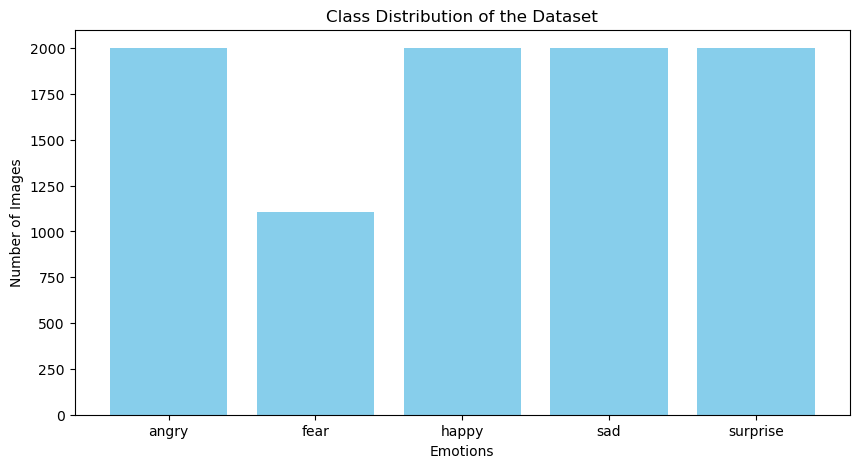

angry: 2000
fear: 1108
happy: 2000
sad: 2000
surprise: 2000


In [18]:
import os
import matplotlib.pyplot as plt

# Count the number of files in each class directory
class_counts = {emotion: len(os.listdir(os.path.join(train_dir, emotion))) for emotion in emotions}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
plt.title('Class Distribution of the Dataset')
plt.show()

# Print the class counts
for emotion, count in class_counts.items():
    print(f'{emotion}: {count}')


We can see that the classes are quite balanced, we just have less images for the "fear" class.
For the moment we are aware of that but do not take any further actions. What we could do is to use over- or undersampling techniques to balance the classes, but we will leave this for now to see how the models perform without any adjustments.

# 2. Data Preparation
To initialize the data preparation we first split the data into a training and validation set to prevent changing the validation data as they should represent unseen real-world data. As we have a quite small dataset after testing around for some time with a 80/20 split we decided to use a 90/10 split for training and validation data, as this gives us more data to train on but still a decent amount of data to validate our models on (although we are well aware of the fact that a 10% validation set is quite small and leads to high fluctuation in validation accuracy scores). We also considered to use no validation set at all when we are confident about our final model to train on the whole dataset to increase the performance of the model.

In [2]:
# Split dataset
train_files, val_files, train_labels, val_labels = train_test_split(file_names, labels, test_size=0.1, random_state=42)

For the preprocessing step we transform our data to enhance the generalization capabilities of our models. We have tried a lot of different data augmentation approaches and had quite a tough time to actually make the models perform better by adapting data augmentation. We tried different combinations of data augmentation techniques (e.g. random rotation, random flips, random color jittering, erasing, etc.) came to the conclusion that less is more in this case and ended up with this simple data augmentation approach:
- Resize the images to 224x224 pixels (as most pretrained models require this size)
- Random horizontal flip 
- Bring images into tensor format
- Normalize the images with the mean and standard deviation of the ImageNet dataset

In [3]:
# Data augmentations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

We then create the dataloaders for the training and validation data. We played around with the batch size and ended up with a batch size of 16, as this gave us the best results in terms of training time and model performance.
We also tried to use a higher batch size of 32, 64 and even 128 but this led to a higher fluctuation in the validation accuracy scores and a longer training time.

In [4]:
train_dataset = EmotionDataset(train_files, train_labels, transform=transform_train)
val_dataset = EmotionDataset(val_files, val_labels, transform=transform_val)

train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=False)

In order to manually check the effect of the data augmentation we can visualize some images after the transformation. At some point we applied pretty heavy augmentation which lead to a very noise image that (at least for a human) was not recognizable as a face anymore. Among other reasons that's why we ended up with the simple data augmentation approach.

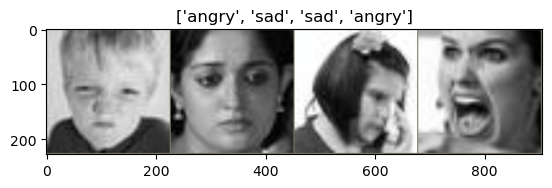

In [5]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

# Get a batch of training data
inputs, classes = next(iter(DataLoader(train_dataset, batch_size=4, shuffle=True)))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[emotions[x] for x in classes])

# 3. Model Selection & Evaluation
In this section we will explore different pretrained models and evaluate their performance on the given dataset. As this report is pretty dense we will only show the results of out most promising models. We have tried many more models and approaches but will only show the most promising ones in this report. We tried to train our own models, use different pretrained models and also tried to use ensemble methods to combine different models. We also tried to use different loss functions, optimizers and learning rates but will only show the most promising results in this report.

To initially decide on what models we want to dig deeper

- give more context:
- why did we choose these models?
- what are the advantages/disadvantages of these models?
- what did we do with the hyperparameters?
- explain what we did, but did not work out

# Densenet

Besides the excersises in class, Densenet was the first model we experimented with. Densenet is a convolutional network that connects each layer to every other layer. It is often named as a good model for image classification. In our approach we use the pretrained weights. There are three fully connected layers with an activation function (ReLu) and one final output layer with the same number of units as our emotion classes. There is also a drouput layer included with a dropout probability of 30%. We experimented with adding more layers and with the dropout rate but experienced the best results with the following configuration.

In [7]:
from torchvision.models import DenseNet121_Weights

def densenet121_extended_model():
    model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )
    return model

# Instantiate the model and move to device
model = densenet121_extended_model()
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In our final runs we used pretty much the same loss function, optimizer and learning rate scheduler for all models. We used the CrossEntropyLoss as loss function, the AdamW optimizer and a learning rate scheduler to reduce the learning rate if the validation loss does not improve for a certain amount of epochs. We also experimented with different learning rates and optimizers but ended up with the following configuration as it gave us the best results in terms of validation accuracy scores and Kaggle F1-Score:

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

NameError: name 'model' is not defined

In [9]:
# Training loop
num_epochs = 25 
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in (train_dl if phase == 'train' else val_dl):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dataset if phase == 'train' else val_dataset)
        epoch_acc = running_corrects / len(train_dataset if phase == 'train' else val_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)
            scheduler.step(epoch_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')

print('Training complete')


Epoch 0/24
----------
train Loss: 1.1688 Acc: 0.5181
val Loss: 0.7213 Acc: 0.7223
Current learning rate: 0.000100
Epoch 1/24
----------
train Loss: 0.7201 Acc: 0.7325
val Loss: 0.5104 Acc: 0.8090
Current learning rate: 0.000100
Epoch 2/24
----------
train Loss: 0.5379 Acc: 0.8061
val Loss: 0.4951 Acc: 0.8200
Current learning rate: 0.000100
Epoch 3/24
----------
train Loss: 0.4079 Acc: 0.8578
val Loss: 0.5166 Acc: 0.8101
Current learning rate: 0.000100
Epoch 4/24
----------
train Loss: 0.3380 Acc: 0.8820
val Loss: 0.4969 Acc: 0.8189
Current learning rate: 0.000100
Epoch 5/24
----------
train Loss: 0.2625 Acc: 0.9103
val Loss: 0.5987 Acc: 0.8057
Current learning rate: 0.000100
Epoch 6/24
----------
train Loss: 0.2288 Acc: 0.9202
val Loss: 0.5352 Acc: 0.8189
Current learning rate: 0.000050
Epoch 7/24
----------
train Loss: 0.1246 Acc: 0.9599
val Loss: 0.4977 Acc: 0.8441
Current learning rate: 0.000050
Epoch 8/24
----------
train Loss: 0.0785 Acc: 0.9727
val Loss: 0.5246 Acc: 0.8452
Curren

In [12]:
# save model
torch.save(model.state_dict(), 'densenet121.pth')

In [13]:
# Test the model
test_dir = 'data/test'
test_files = [os.path.join(test_dir, img_file) for img_file in os.listdir(test_dir)]
test_dataset = EmotionDataset(test_files, transform=transform_val)
test_dl = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
results = []

for inputs in test_dl:
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        results.extend(preds)

results_df = pd.DataFrame({'Id': [os.path.basename(file) for file in test_files], 'emotions': [emotions[pred] for pred in results]})
results_df.to_csv('predictions_densenet121.csv', index=False)

We achieved a validation accuracy of ~85% with the Densenet121 model and a Kaggle score of 82,5%.

# SWIN Transformer

Next up we tried different Vision Transformer models. After reading some papers and testing around with different models we decided to use the Swin Transformer. The Swin Transformer is a transformer model that is designed to handle images. It is a hierarchical transformer model that divides the image into patches and processes them in a hierarchical way. The Swin Transformer is known for its good performance on image classification tasks. In this model we added a fully connected layer and a dropout layer with the probability of 30%. We initialize a learning rate scheduler to try out different learning rates for our training. For the Swin transformer we had some challenges to prevent overfitting and tried different approaches to optimize the model (increase weights and biases, dropout, data augmentation). We also tried to use different learning rates and optimizers but ended up with the following configuration as it gave us the best results in terms of validation accuracy scores and Kaggle score.

We also tried around with different swin models. We finally used the tiny version of the model, as the base and large version of Swin trained for a very very long time (20h+ on our local machine with GPU on a NVIDIA 3080 TI) and did just slightly perform better than the tiny version. The minor improvement in performance was not worth the time we had to invest to train the model.

In [7]:
# Define Swin Transformer model 
class SwinEmotionModel(nn.Module):
    def __init__(self, num_classes):
        super(SwinEmotionModel, self).__init__()
        # https://pytorch.org/vision/main/models/swin_transformer.html
        self.swin = models.swin_v2_t(weights='IMAGENET1K_V1')
        self.swin.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.swin.head.in_features, num_classes)
        )

    def forward(self, x):
        x = self.swin(x)
        return x

model = SwinEmotionModel(num_classes=num_classes).to(device)

We also tested to introduce early stopping (stop training after certain epochs if no improvement is made) to prevent overfitting but did not achieve any improvements in the validation accuracy scores.

In [8]:
# class for early stopping - not used currently
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [9]:
# Define optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Epoch 0/24
----------
train Loss: 1.1633 Acc: 0.5306
val Loss: 0.7383 Acc: 0.7025
Current learning rate: 0.000100
Epoch 1/24
----------
train Loss: 0.7659 Acc: 0.7107
val Loss: 0.6162 Acc: 0.7563
Current learning rate: 0.000100
Epoch 2/24
----------
train Loss: 0.5942 Acc: 0.7802
val Loss: 0.5564 Acc: 0.7783
Current learning rate: 0.000100
Epoch 3/24
----------
train Loss: 0.4753 Acc: 0.8253
val Loss: 0.5851 Acc: 0.7827
Current learning rate: 0.000100
Epoch 4/24
----------
train Loss: 0.3839 Acc: 0.8625
val Loss: 0.6111 Acc: 0.7805
Current learning rate: 0.000100
Epoch 5/24
----------
train Loss: 0.3124 Acc: 0.8891
val Loss: 0.5840 Acc: 0.7958
Current learning rate: 0.000100
Epoch 6/24
----------
train Loss: 0.2619 Acc: 0.9055
val Loss: 0.5572 Acc: 0.8101
Current learning rate: 0.000050
Epoch 7/24
----------
train Loss: 0.1439 Acc: 0.9511
val Loss: 0.5685 Acc: 0.8233
Current learning rate: 0.000050
Epoch 8/24
----------
train Loss: 0.1062 Acc: 0.9628
val Loss: 0.6128 Acc: 0.8233
Curren

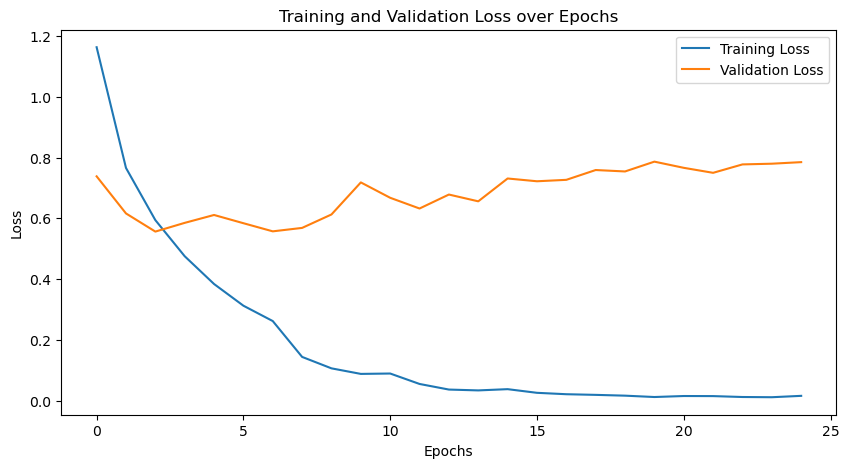

In [10]:
# Training loop with early stopping
num_epochs = 25  # Number of epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in (train_dl if phase == 'train' else val_dl):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dataset if phase == 'train' else val_dataset)
        epoch_acc = running_corrects / len(train_dataset if phase == 'train' else val_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)
            scheduler.step(epoch_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')

print('Training complete')

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'swin_transformer_emotion_model.pth')

In [11]:
# Test the model
test_dir = 'data/test'
test_files = [os.path.join(test_dir, img_file) for img_file in os.listdir(test_dir)]
test_dataset = EmotionDataset(test_files, transform=transform_val)
test_dl = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
results = []

for inputs in test_dl:
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        results.extend(preds)

results_df = pd.DataFrame({'Id': [os.path.basename(file) for file in test_files], 'emotions': [emotions[pred] for pred in results]})
results_df.to_csv('predictions_swin.csv', index=False)

We achieved a validation accuracy of ~XX% with the Swin model and a Kaggle score of XX%.

# Resnet

After trying many different things with Densenet and Swin we went "back to basic" and just used a simple Resnet model which we already know is a pretty common choice for image classification due to the course. We did that because we've observed that it seems like (especially for pretrained models) they seem to perform best on our optimization problem if we don't modify them too much and not overcomplicate things. We used the Resnet18 and Resnet50 model and experimented with different fully connected layers and dropout rates. We also tried to use different learning rates and optimizers but ended up with the following configuration as it gave us the best results in terms of validation accuracy scores and Kaggle score.  

The main difference between RESNET18 and RESNET50 is the size of its layers with RESNET18 having 18 layers and RESNET50 having 50 layers. In the course exercises we mostly worked with RESNET18, but in this notebook we will also have a look at RESNET50.

## Resnet18

We started with Resnet18 to check the validity of Resnet to solve our classification problem having in mind that we can switch to Resnet50 if we need more complexity.  
We achieved a validation accuracy of XXXX% with this model and a Kaggle score of XXXX%.

## 4. Conclusion
- describe that we used esemble methods to combine different models and grid search to find the best hyperparameters
- Tough times with overfitting. We tried everything to optimize that - weights and biases, dropout, data augmentation, early stopping, etc. - as nothing helped to much, we don't have to much regularization in the final model
- mention limitations (e.g. data quality, model performance, complexity of training in order to achieve slightly better results)
- explain things we considered but did not implement as k-fold cross validation, more extended grid search for more models, etc.